In [110]:
import carla
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import json
import statistics

In [111]:
def read_all_json_files_in_directory(directory_path):
    """
    Finds, reads, and parses all JSON files in a given directory.

    Args:
        directory_path (str): The path to the directory to search.

    Returns:
        list: A list containing the parsed data from each JSON file.
              Returns an empty list if no files are found or an error occurs.
    """
    # 1. Create a search pattern to find all files ending with .json
    #    os.path.join is the recommended way to build file paths.
    search_pattern = os.path.join(directory_path, '*.json')

    # 2. Use glob.glob() to get a list of all file paths that match the pattern.
    json_file_paths = glob.glob(search_pattern)

    if not json_file_paths:
        print(f"Warning: No JSON files found in '{directory_path}'")
        return []

    print(f"Found {len(json_file_paths)} files to process.")

    all_data = []
    # 3. Loop through the list of file paths.
    for file_path in json_file_paths:
        # print(f"--> Reading '{os.path.basename(file_path)}'...")
        try:
            # 4. Open and read the file. The 'with' statement ensures the
            #    file is automatically closed, even if errors occur.
            with open(file_path, 'r') as f:
                # 5. Use json.load() to parse the JSON content into a Python dict.
                data = json.load(f)
                all_data.append(data)
                # print(f"    ...success. Loaded {len(data.get('frames', []))} data points.")

        except json.JSONDecodeError:
            print(f"    ...Error: Failed to decode JSON from '{file_path}'. File may be corrupt or empty.")
        except Exception as e:
            print(f"    ...An unexpected error occurred with file '{file_path}': {e}")

    return all_data



In [112]:
LKA_20ms_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Follow Leading Vehicle data/Distance between Vehicles/LKA_20ms_delay"
LKA_35ms_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Follow Leading Vehicle data/Distance between Vehicles/LKA_35ms_delay"
LKA_100ms_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Follow Leading Vehicle data/Distance between Vehicles/LKA_100ms_delay"
LKA_no_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Follow Leading Vehicle data/Distance between Vehicles/LKA_no_delay"

no_LKA_20ms_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Follow Leading Vehicle data/Distance between Vehicles/no_LKA_20ms_delay"
no_LKA_35ms_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Follow Leading Vehicle data/Distance between Vehicles/no_LKA_35ms_delay"
no_LKA_100ms_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Follow Leading Vehicle data/Distance between Vehicles/no_LKA_100ms_delay"
no_LKA_no_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Follow Leading Vehicle data/Distance between Vehicles/no_LKA_no_delay"

LKA_20ms_delay_data = read_all_json_files_in_directory(LKA_20ms_delay)
LKA_35ms_delay_data = read_all_json_files_in_directory(LKA_35ms_delay)
LKA_100ms_delay_data = read_all_json_files_in_directory(LKA_100ms_delay)
LKA_no_delay_data = read_all_json_files_in_directory(LKA_no_delay)

no_LKA_20ms_delay_data = read_all_json_files_in_directory(no_LKA_20ms_delay)
no_LKA_35ms_delay_data = read_all_json_files_in_directory(no_LKA_35ms_delay)
no_LKA_100ms_delay_data = read_all_json_files_in_directory(no_LKA_100ms_delay)
no_LKA_no_delay_data = read_all_json_files_in_directory(no_LKA_no_delay)
follow_data_list=[LKA_20ms_delay_data,LKA_35ms_delay_data,LKA_100ms_delay_data,LKA_no_delay_data,no_LKA_20ms_delay_data,no_LKA_35ms_delay_data,no_LKA_100ms_delay_data,no_LKA_no_delay_data]
for a in follow_data_list:
    for i in range(6):
        for j in range(len(a[i]['distance'])):
            a[i]['distance'][j]=round(a[i]['distance'][j],1)
  

Found 6 files to process.
Found 6 files to process.
Found 6 files to process.
Found 6 files to process.
Found 6 files to process.
Found 6 files to process.
Found 6 files to process.
Found 6 files to process.


# Scenario 2 Following Leading vehicle 60kmh

## Plot distance from leading vehicle

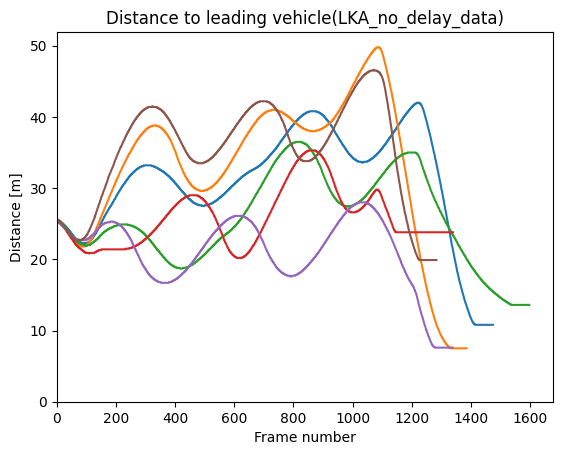

In [113]:
for i in range(6):
    plt.plot(range(len(LKA_no_delay_data[i]['distance'][LKA_no_delay_data[i]['distance'].count(25.7):])), LKA_no_delay_data[i]['distance'][LKA_no_delay_data[i]['distance'].count(25.7):])

plt.ylabel('Distance [m]')
plt.xlabel('Frame number')
plt.title('Distance to leading vehicle(LKA_no_delay_data)')
# Set x-axis limit to start from 0
plt.xlim(xmin=0) 

# Set y-axis limit to start from 0
plt.ylim(ymin=0) 
plt.show()

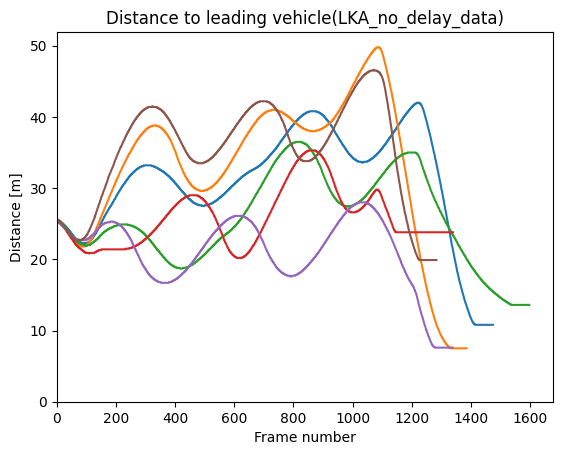

In [114]:

for i in range(6):
    plt.plot(range(0,len(LKA_no_delay_data[i]['distance'][LKA_no_delay_data[i]['distance'].count(25.7):])), LKA_no_delay_data[i]['distance'][LKA_no_delay_data[i]['distance'].count(25.7):])

plt.ylabel('Distance [m]')
plt.xlabel('Frame number')
plt.title('Distance to leading vehicle(LKA_no_delay_data)')
# Set x-axis limit to start from 0
plt.xlim(xmin=0) 

# Set y-axis limit to start from 0
plt.ylim(ymin=0) 
plt.show()

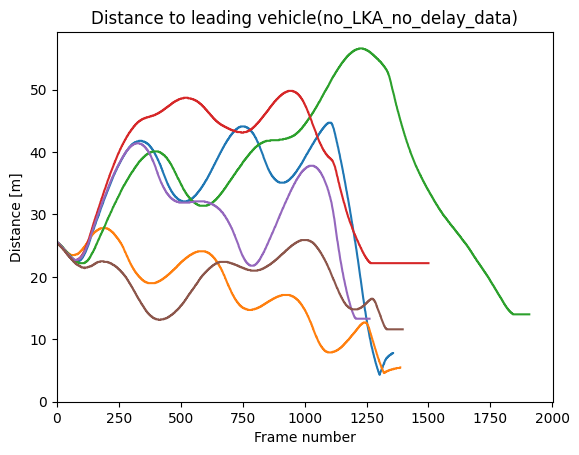

In [115]:

for i in range(6):
    plt.plot(range(0,len(no_LKA_no_delay_data[i]['distance'][no_LKA_no_delay_data[i]['distance'].count(25.7):])), no_LKA_no_delay_data[i]['distance'][no_LKA_no_delay_data[i]['distance'].count(25.7):])

plt.ylabel('Distance [m]')
plt.xlabel('Frame number')
plt.title('Distance to leading vehicle(no_LKA_no_delay_data)')
# Set x-axis limit to start from 0
plt.xlim(xmin=0) 

# Set y-axis limit to start from 0
plt.ylim(ymin=0) 
plt.show()

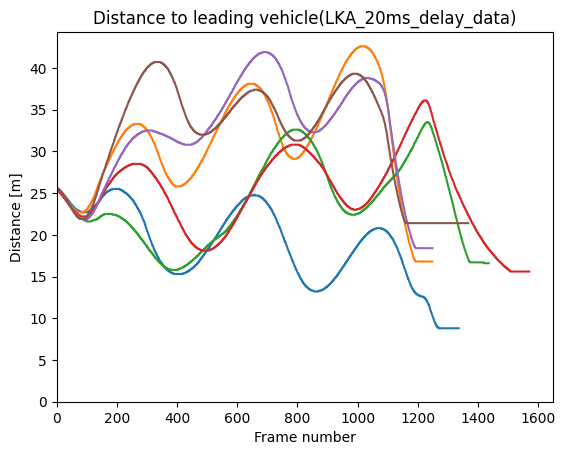

In [116]:

for i in range(6):
    plt.plot(range(len(LKA_20ms_delay_data[i]['distance'][LKA_20ms_delay_data[i]['distance'].count(25.7):])), LKA_20ms_delay_data[i]['distance'][LKA_20ms_delay_data[i]['distance'].count(25.7):])

plt.ylabel('Distance [m]')
plt.xlabel('Frame number')
plt.title('Distance to leading vehicle(LKA_20ms_delay_data)')
# Set x-axis limit to start from 0
plt.xlim(xmin=0) 

# Set y-axis limit to start from 0
plt.ylim(ymin=0) 
plt.show()

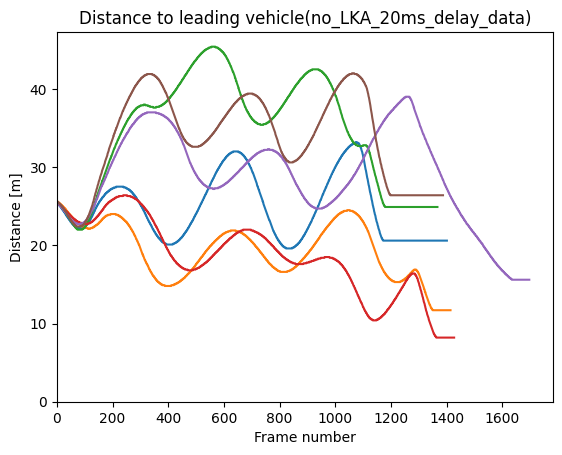

In [117]:

for i in range(6):
    plt.plot(range(len(no_LKA_20ms_delay_data[i]['distance'][no_LKA_20ms_delay_data[i]['distance'].count(25.7):])), no_LKA_20ms_delay_data[i]['distance'][no_LKA_20ms_delay_data[i]['distance'].count(25.7):])

plt.ylabel('Distance [m]')
plt.xlabel('Frame number')
plt.title('Distance to leading vehicle(no_LKA_20ms_delay_data)')
# Set x-axis limit to start from 0
plt.xlim(xmin=0) 

# Set y-axis limit to start from 0
plt.ylim(ymin=0) 
plt.show()

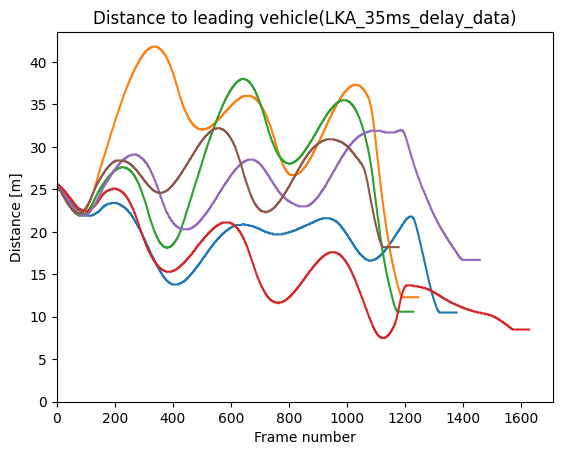

In [118]:

for i in range(6):
    plt.plot(range(len(LKA_35ms_delay_data[i]['distance'][LKA_35ms_delay_data[i]['distance'].count(25.7):])), LKA_35ms_delay_data[i]['distance'][LKA_35ms_delay_data[i]['distance'].count(25.7):])

plt.ylabel('Distance [m]')
plt.xlabel('Frame number')
plt.title('Distance to leading vehicle(LKA_35ms_delay_data)')
# Set x-axis limit to start from 0
plt.xlim(xmin=0) 

# Set y-axis limit to start from 0
plt.ylim(ymin=0) 
plt.show()

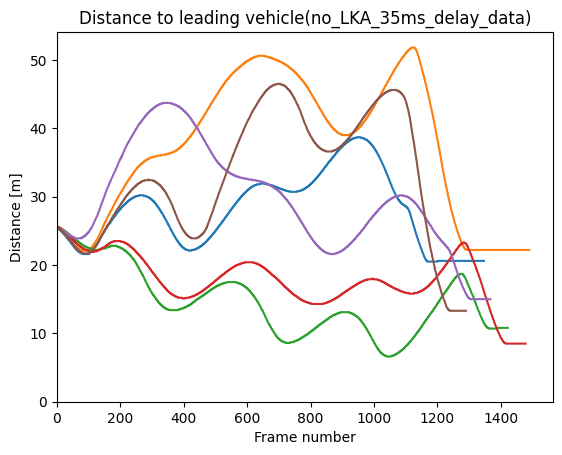

In [119]:

for i in range(6):
    plt.plot(range(len(no_LKA_35ms_delay_data[i]['distance'][no_LKA_35ms_delay_data[i]['distance'].count(25.7):])), no_LKA_35ms_delay_data[i]['distance'][no_LKA_35ms_delay_data[i]['distance'].count(25.7):])

plt.ylabel('Distance [m]')
plt.xlabel('Frame number')
plt.title('Distance to leading vehicle(no_LKA_35ms_delay_data)')
# Set x-axis limit to start from 0
plt.xlim(xmin=0) 

# Set y-axis limit to start from 0
plt.ylim(ymin=0) 
plt.show()

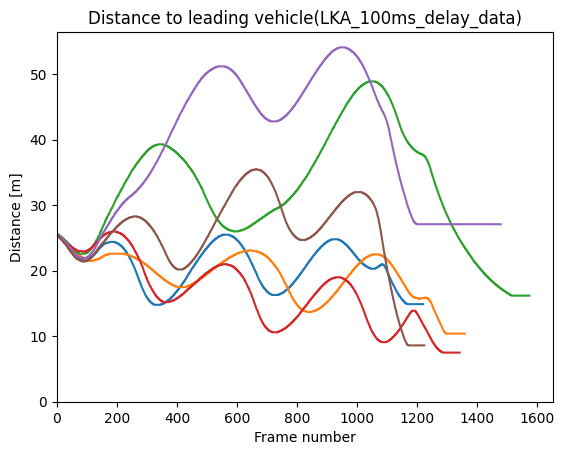

In [120]:
for i in range(6):
    plt.plot(range(len(LKA_100ms_delay_data[i]['distance'][LKA_100ms_delay_data[i]['distance'].count(25.7):])), LKA_100ms_delay_data[i]['distance'][LKA_100ms_delay_data[i]['distance'].count(25.7):])

plt.ylabel('Distance [m]')
plt.xlabel('Frame number')
plt.title('Distance to leading vehicle(LKA_100ms_delay_data)')
# Set x-axis limit to start from 0
plt.xlim(xmin=0) 

# Set y-axis limit to start from 0
plt.ylim(ymin=0) 
plt.show()

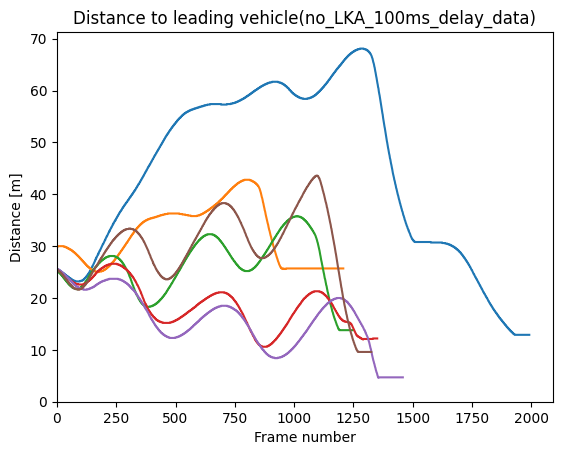

In [121]:
for i in range(6):
    plt.plot(range(len(no_LKA_100ms_delay_data[i]['distance'][no_LKA_100ms_delay_data[i]['distance'].count(25.7):])), no_LKA_100ms_delay_data[i]['distance'][no_LKA_100ms_delay_data[i]['distance'].count(25.7):])

plt.ylabel('Distance [m]')
plt.xlabel('Frame number')
plt.title('Distance to leading vehicle(no_LKA_100ms_delay_data)')
# Set x-axis limit to start from 0
plt.xlim(xmin=0) 

# Set y-axis limit to start from 0
plt.ylim(ymin=0) 
plt.show()

## Average and variance

In [122]:
LKA_20ms_delay = []
LKA_35ms_delay = []
LKA_100ms_delay = []
LKA_no_delay = []

no_LKA_20ms_delay = []
no_LKA_35ms_delay = []
no_LKA_100ms_delay = []
no_LKA_no_delay = []
average_data_list = [no_LKA_no_delay, LKA_no_delay, no_LKA_20ms_delay,LKA_20ms_delay,  no_LKA_35ms_delay,LKA_35ms_delay,no_LKA_100ms_delay, LKA_100ms_delay  ]
average_data_list_name= ['no_LKA_no_delay', 'LKA_no_delay', 'no_LKA_20ms_delay','LKA_20ms_delay', 'no_LKA_35ms_delay','LKA_35ms_delay','no_LKA_100ms_delay', 'LKA_100ms_delay' ]
        

In [123]:
for i in range(8):
    for j in range(6):
        average_data_list[i].extend(follow_data_list[i][j]['distance'][follow_data_list[i][j]['distance'].count(25.7):])
for data_list in average_data_list:
    
    cleaned_data = []
    for item in data_list:
        try:
            # Try to convert each item to a float
            cleaned_data.append(float(item))
        except (ValueError, TypeError):
            # If it fails (e.g., it's a non-numeric string like 'N/A'), just skip it
            continue

average_data_list = []
std_dev_data_list = []
for data in follow_data_list:
    all_distances = []
    for i in range(len(data)):
        # The first few values are not part of the actual data, so we skip them
        cleaned_data = data[i]['distance'][data[i]['distance'].count(25.7):]
        all_distances.extend(cleaned_data)
    
    average_data_list.append(statistics.mean(all_distances))
    std_dev_data_list.append(statistics.stdev(all_distances))

results_df = pd.DataFrame({
    'Average(m)': average_data_list,
    'Standard Deviation(m)': std_dev_data_list
}, index=average_data_list_name)

print(results_df)

                    Average(m)  Standard Deviation(m)
no_LKA_no_delay      26.809374               7.455115
LKA_no_delay         23.594045               7.449607
no_LKA_20ms_delay    25.836665              10.481475
LKA_20ms_delay       28.437304               8.535709
no_LKA_35ms_delay    26.569445               8.216667
LKA_35ms_delay       26.560131              10.841715
no_LKA_100ms_delay   28.636708              13.899146
LKA_100ms_delay      29.417325              11.735953


## Plot distance to lane center

In [124]:
LKA_20ms_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Follow Leading Vehicle data/Distance to lane center/LKA_20ms_delay"
LKA_35ms_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Follow Leading Vehicle data/Distance to lane center/LKA_35ms_delay"
LKA_100ms_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Follow Leading Vehicle data/Distance to lane center/LKA_100ms_delay"
LKA_no_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Follow Leading Vehicle data/Distance to lane center/LKA_no_delay"

no_LKA_20ms_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Follow Leading Vehicle data/Distance to lane center/no_LKA_20ms_delay"
no_LKA_35ms_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Follow Leading Vehicle data/Distance to lane center/no_LKA_35ms_delay"
no_LKA_100ms_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Follow Leading Vehicle data/Distance to lane center/no_LKA_100ms_delay"
no_LKA_no_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Follow Leading Vehicle data/Distance to lane center/no_LKA_no_delay"

LKA_20ms_delay_data = read_all_json_files_in_directory(LKA_20ms_delay)
LKA_35ms_delay_data = read_all_json_files_in_directory(LKA_35ms_delay)
LKA_100ms_delay_data = read_all_json_files_in_directory(LKA_100ms_delay)
LKA_no_delay_data = read_all_json_files_in_directory(LKA_no_delay)

no_LKA_20ms_delay_data = read_all_json_files_in_directory(no_LKA_20ms_delay)
no_LKA_35ms_delay_data = read_all_json_files_in_directory(no_LKA_35ms_delay)
no_LKA_100ms_delay_data = read_all_json_files_in_directory(no_LKA_100ms_delay)
no_LKA_no_delay_data = read_all_json_files_in_directory(no_LKA_no_delay)
follow_data_list=[LKA_20ms_delay_data,LKA_35ms_delay_data,LKA_100ms_delay_data,LKA_no_delay_data,no_LKA_20ms_delay_data,no_LKA_35ms_delay_data,no_LKA_100ms_delay_data,no_LKA_no_delay_data]
for a in follow_data_list:
    for i in range(6):
        for j in range(len(a[i]['distance'])):
            a[i]['distance'][j]=round(a[i]['distance'][j],2)
   

Found 6 files to process.
Found 6 files to process.
Found 6 files to process.
Found 6 files to process.
Found 6 files to process.
Found 6 files to process.
Found 6 files to process.
Found 6 files to process.


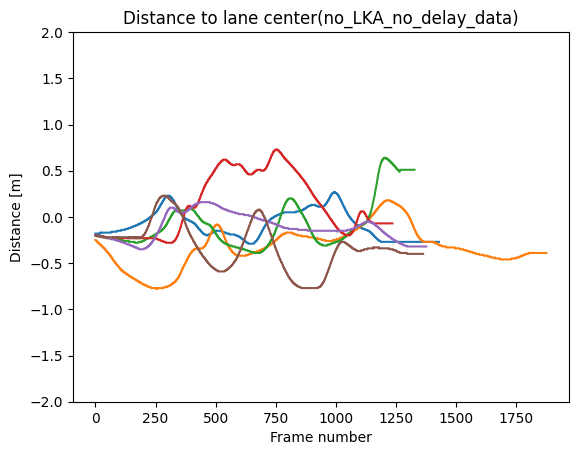

In [125]:
for i in range(6):
    plt.plot(range(len(no_LKA_no_delay_data[i]['distance'][no_LKA_no_delay_data[i]['distance'].count(-0.19):])), no_LKA_no_delay_data[i]['distance'][no_LKA_no_delay_data[i]['distance'].count(-0.19):])

plt.ylabel('Distance [m]')
plt.xlabel('Frame number')
plt.title('Distance to lane center(no_LKA_no_delay_data)')
# # Set x-axis limit to start from 0
# plt.xlim(xmin=0) 

# # Set y-axis limit to start from 0
# plt.ylim(ymin=0) 
plt.ylim(-2,2) 
plt.show()

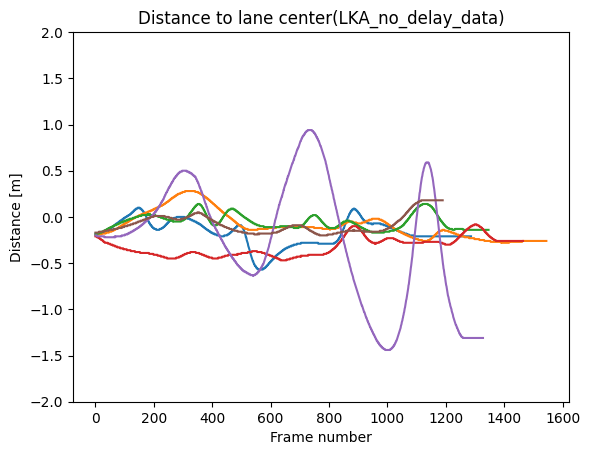

In [126]:
for i in range(6):
    plt.plot(range(len(LKA_no_delay_data[i]['distance'][LKA_no_delay_data[i]['distance'].count(-0.19):])), LKA_no_delay_data[i]['distance'][LKA_no_delay_data[i]['distance'].count(-0.19):])

plt.ylabel('Distance [m]')
plt.xlabel('Frame number')
plt.title('Distance to lane center(LKA_no_delay_data)')
# # Set x-axis limit to start from 0
# plt.xlim(xmin=0) 

# # Set y-axis limit to start from 0
plt.ylim(-2,2) 
plt.show()

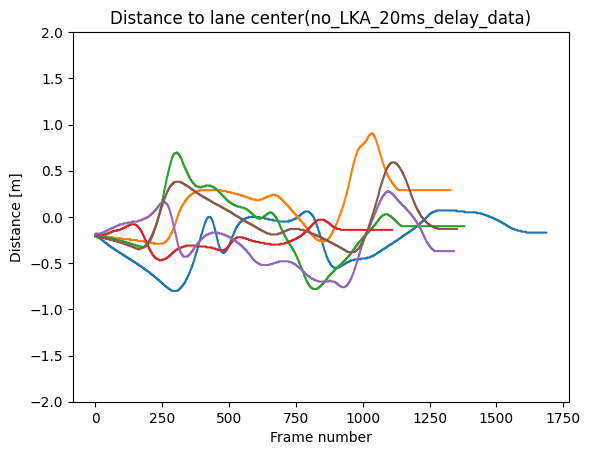

In [127]:
for i in range(6):
    plt.plot(range(len(no_LKA_20ms_delay_data[i]['distance'][no_LKA_20ms_delay_data[i]['distance'].count(-0.19):])), no_LKA_20ms_delay_data[i]['distance'][no_LKA_20ms_delay_data[i]['distance'].count(-0.19):])

plt.ylabel('Distance [m]')
plt.xlabel('Frame number')
plt.title('Distance to lane center(no_LKA_20ms_delay_data)')
# # Set x-axis limit to start from 0
# plt.xlim(xmin=0) 

# # Set y-axis limit to start from 0
# plt.ylim(ymin=0) 
plt.ylim(-2,2) 
plt.show()

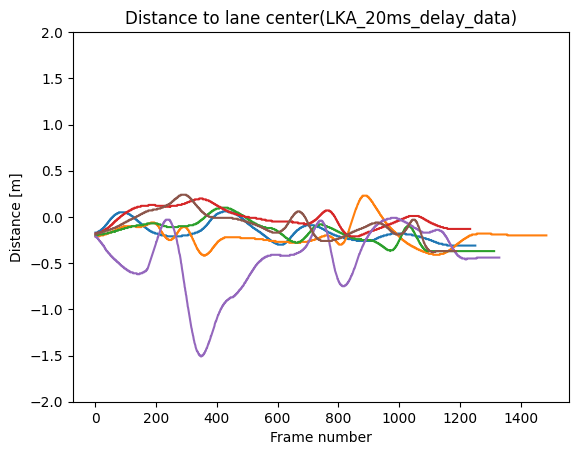

In [128]:
for i in range(6):
    plt.plot(range(len(LKA_20ms_delay_data[i]['distance'][LKA_20ms_delay_data[i]['distance'].count(-0.19):])), LKA_20ms_delay_data[i]['distance'][LKA_20ms_delay_data[i]['distance'].count(-0.19):])

plt.ylabel('Distance [m]')
plt.xlabel('Frame number')
plt.title('Distance to lane center(LKA_20ms_delay_data)')
# # Set x-axis limit to start from 0
# plt.xlim(xmin=0) 

# # Set y-axis limit to start from 0
# plt.ylim(ymin=0) 
plt.ylim(-2,2) 
plt.show()

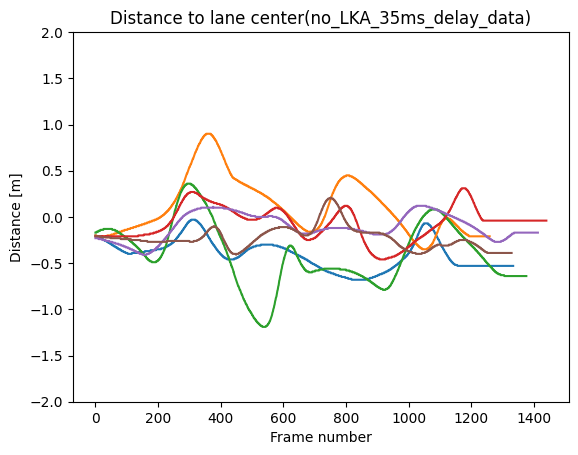

In [129]:
for i in range(6):
    plt.plot(range(len(no_LKA_35ms_delay_data[i]['distance'][no_LKA_35ms_delay_data[i]['distance'].count(-0.19):])), no_LKA_35ms_delay_data[i]['distance'][no_LKA_35ms_delay_data[i]['distance'].count(-0.19):])

plt.ylabel('Distance [m]')
plt.xlabel('Frame number')
plt.title('Distance to lane center(no_LKA_35ms_delay_data)')
# # Set x-axis limit to start from 0
# plt.xlim(xmin=0) 

# # Set y-axis limit to start from 0
# plt.ylim(ymin=0) 
plt.ylim(-2,2) 
plt.show()

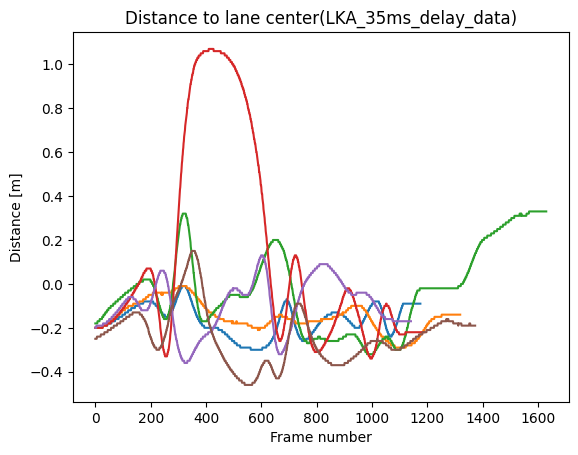

In [130]:
for i in range(6):
    plt.plot(range(len(LKA_35ms_delay_data[i]['distance'][LKA_35ms_delay_data[i]['distance'].count(-0.19):])), LKA_35ms_delay_data[i]['distance'][LKA_35ms_delay_data[i]['distance'].count(-0.19):])

plt.ylabel('Distance [m]')
plt.xlabel('Frame number')
plt.title('Distance to lane center(LKA_35ms_delay_data)')
# # Set x-axis limit to start from 0
# plt.xlim(xmin=0) 

# # Set y-axis limit to start from 0
# plt.ylim(ymin=0)
# plt.ylim(-2,2)  
plt.show()

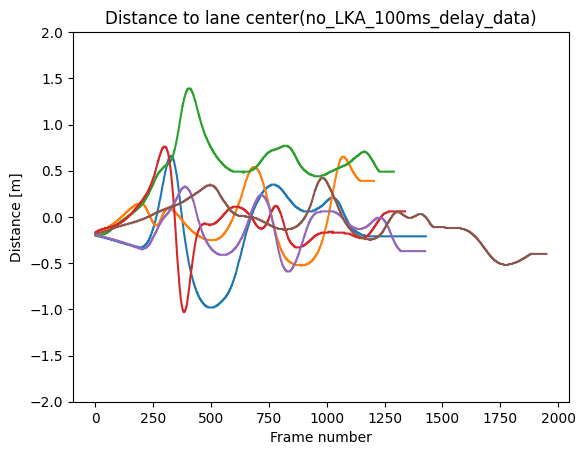

In [131]:
for i in range(6):
    plt.plot(range(len(no_LKA_100ms_delay_data[i]['distance'][no_LKA_100ms_delay_data[i]['distance'].count(-0.19):])), no_LKA_100ms_delay_data[i]['distance'][no_LKA_100ms_delay_data[i]['distance'].count(-0.19):])

plt.ylabel('Distance [m]')
plt.xlabel('Frame number')
plt.title('Distance to lane center(no_LKA_100ms_delay_data)')
# # Set x-axis limit to start from 0
# plt.xlim(xmin=0) 

# # Set y-axis limit to start from 0
# plt.ylim(ymin=0) 
plt.ylim(-2,2) 
plt.show()

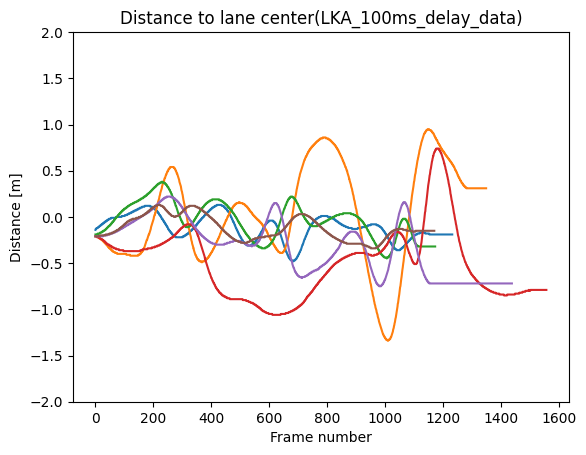

In [132]:
for i in range(6):
    plt.plot(range(len(LKA_100ms_delay_data[i]['distance'][LKA_100ms_delay_data[i]['distance'].count(-0.19):])), LKA_100ms_delay_data[i]['distance'][LKA_100ms_delay_data[i]['distance'].count(-0.19):])

plt.ylabel('Distance [m]')
plt.xlabel('Frame number')
plt.title('Distance to lane center(LKA_100ms_delay_data)')
# # Set x-axis limit to start from 0
# plt.xlim(xmin=0) 

# # Set y-axis limit to start from 0
# plt.ylim(ymin=0) 
plt.ylim(-2,2) 
plt.show()

In [133]:
LKA_20ms_delay = []
LKA_35ms_delay = []
LKA_100ms_delay = []
LKA_no_delay = []

no_LKA_20ms_delay = []
no_LKA_35ms_delay = []
no_LKA_100ms_delay = []
no_LKA_no_delay = []
average_data_list = [no_LKA_no_delay, LKA_no_delay, no_LKA_20ms_delay,LKA_20ms_delay,  no_LKA_35ms_delay,LKA_35ms_delay,no_LKA_100ms_delay, LKA_100ms_delay  ]

In [134]:
for i in range(8):
    for j in range(6):
        average_data_list[i].extend(follow_data_list[i][j]['distance'][follow_data_list[i][j]['distance'].count(-0.19):])
for data_list in average_data_list:
    
    cleaned_data = []
    for item in data_list:
        try:
            # Try to convert each item to a float
            cleaned_data.append(float(item))
        except (ValueError, TypeError):
            # If it fails (e.g., it's a non-numeric string like 'N/A'), just skip it
            continue


average_data_list = []
std_dev_data_list = []
for data in follow_data_list:
    all_distances = []
    for i in range(len(data)):
        # The first few values are not part of the actual data, so we skip them
        cleaned_data = data[i]['distance'][data[i]['distance'].count(-0.19):]
        all_distances.extend(cleaned_data)
    
    average_data_list.append(statistics.mean(all_distances))
    std_dev_data_list.append(statistics.stdev(all_distances))

results_df = pd.DataFrame({
    'Average(m)': average_data_list,
    'Standard Deviation(m)': std_dev_data_list
}, index=average_data_list_name)

print(results_df)

                    Average(m)  Standard Deviation(m)
no_LKA_no_delay      -0.186786               0.225843
LKA_no_delay         -0.092890               0.247101
no_LKA_20ms_delay    -0.192825               0.379177
LKA_20ms_delay       -0.162948               0.303442
no_LKA_35ms_delay    -0.122901               0.296511
LKA_35ms_delay       -0.185807               0.289637
no_LKA_100ms_delay    0.003285               0.365797
LKA_100ms_delay      -0.146790               0.280571


# Scenario 1 Urban driving 60kmh

## plot distance to lane center

In [135]:
LKA_20ms_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Free ride data/20ms_delay_LKA"
LKA_35ms_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Free ride data/35ms_delay_LKA"
LKA_100ms_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Free ride data/100ms_delay_LKA"
LKA_no_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Free ride data/no_delay_LKA"

no_LKA_20ms_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Free ride data/20ms_delay_no_LKA"
no_LKA_35ms_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Free ride data/35ms_delay_no_LKA"
no_LKA_100ms_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Free ride data/100ms_delay_no_LKA"
no_LKA_no_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Free ride data/no_delay_no_LKA"

LKA_20ms_delay_data = read_all_json_files_in_directory(LKA_20ms_delay)
LKA_35ms_delay_data = read_all_json_files_in_directory(LKA_35ms_delay)
LKA_100ms_delay_data = read_all_json_files_in_directory(LKA_100ms_delay)
LKA_no_delay_data = read_all_json_files_in_directory(LKA_no_delay)

no_LKA_20ms_delay_data = read_all_json_files_in_directory(no_LKA_20ms_delay)
no_LKA_35ms_delay_data = read_all_json_files_in_directory(no_LKA_35ms_delay)
no_LKA_100ms_delay_data = read_all_json_files_in_directory(no_LKA_100ms_delay)
no_LKA_no_delay_data = read_all_json_files_in_directory(no_LKA_no_delay)
follow_data_list=[LKA_20ms_delay_data,LKA_35ms_delay_data,LKA_100ms_delay_data,LKA_no_delay_data,no_LKA_20ms_delay_data,no_LKA_35ms_delay_data,no_LKA_100ms_delay_data,no_LKA_no_delay_data]
for a in follow_data_list:
    for i in range(6):
        for j in range(len(a[i]['distance'])):
            a[i]['distance'][j]=round(a[i]['distance'][j],2)
   

Found 6 files to process.
Found 6 files to process.
Found 6 files to process.
Found 6 files to process.
Found 6 files to process.
Found 6 files to process.
Found 6 files to process.
Found 6 files to process.


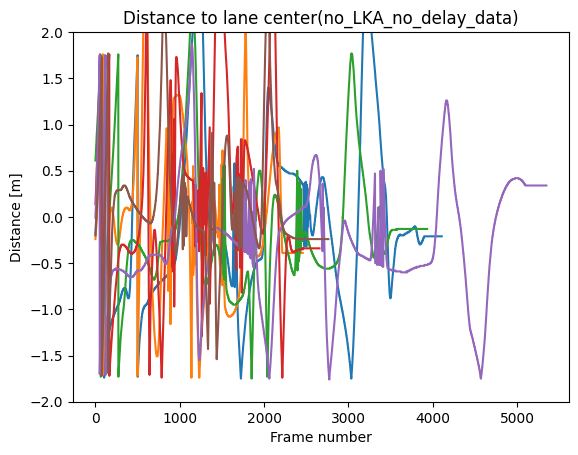

In [136]:
for i in range(6):
    plt.plot(range(len(no_LKA_no_delay_data[i]['distance'][no_LKA_no_delay_data[i]['distance'].count(-0.31):])), no_LKA_no_delay_data[i]['distance'][no_LKA_no_delay_data[i]['distance'].count(-0.31):])

plt.ylabel('Distance [m]')
plt.xlabel('Frame number')
plt.title('Distance to lane center(no_LKA_no_delay_data)')
# # Set x-axis limit to start from 0
# plt.xlim(xmin=0) 

# # Set y-axis limit to start from 0
# plt.ylim(ymin=0) 
plt.ylim(-2,2) 
plt.show()

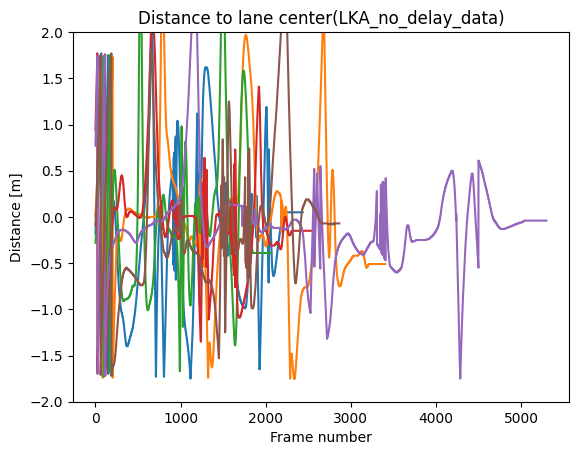

In [137]:
for i in range(6):
    plt.plot(range(len(LKA_no_delay_data[i]['distance'][LKA_no_delay_data[i]['distance'].count(-0.31):])), LKA_no_delay_data[i]['distance'][LKA_no_delay_data[i]['distance'].count(-0.31):])

plt.ylabel('Distance [m]')
plt.xlabel('Frame number')
plt.title('Distance to lane center(LKA_no_delay_data)')
# # Set x-axis limit to start from 0
# plt.xlim(xmin=0) 

# # Set y-axis limit to start from 0
plt.ylim(-2,2) 
plt.show()

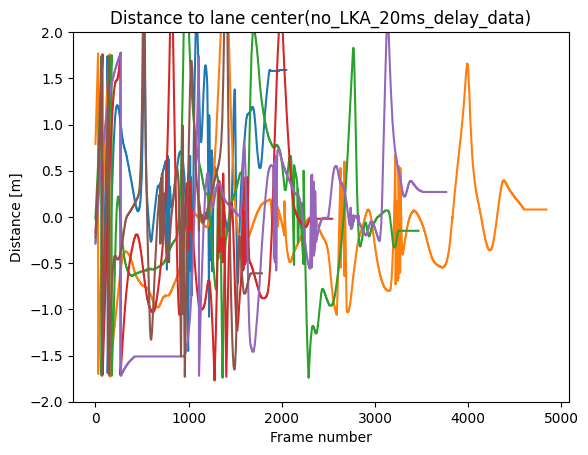

In [138]:
for i in range(6):
    plt.plot(range(len(no_LKA_20ms_delay_data[i]['distance'][no_LKA_20ms_delay_data[i]['distance'].count(-0.31):])), no_LKA_20ms_delay_data[i]['distance'][no_LKA_20ms_delay_data[i]['distance'].count(-0.31):])

plt.ylabel('Distance [m]')
plt.xlabel('Frame number')
plt.title('Distance to lane center(no_LKA_20ms_delay_data)')
# # Set x-axis limit to start from 0
# plt.xlim(xmin=0) 

# # Set y-axis limit to start from 0
# plt.ylim(ymin=0) 
plt.ylim(-2,2) 
plt.show()

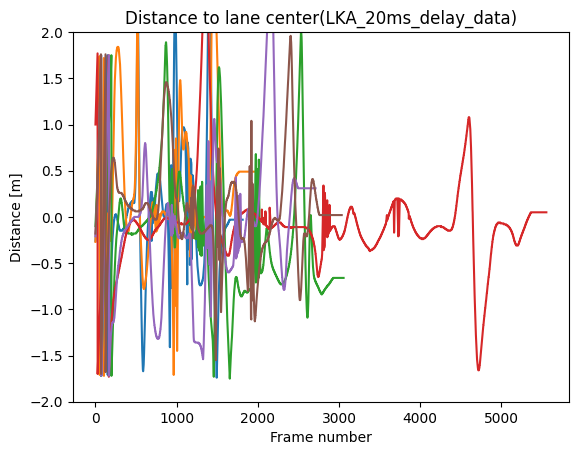

In [139]:
for i in range(6):
    plt.plot(range(len(LKA_20ms_delay_data[i]['distance'][LKA_20ms_delay_data[i]['distance'].count(-0.31):])), LKA_20ms_delay_data[i]['distance'][LKA_20ms_delay_data[i]['distance'].count(-0.31):])

plt.ylabel('Distance [m]')
plt.xlabel('Frame number')
plt.title('Distance to lane center(LKA_20ms_delay_data)')
# # Set x-axis limit to start from 0
# plt.xlim(xmin=0) 

# # Set y-axis limit to start from 0
# plt.ylim(ymin=0) 
plt.ylim(-2,2) 
plt.show()

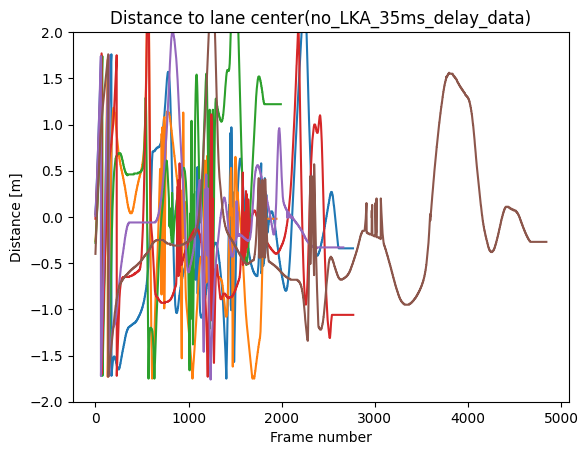

In [140]:
for i in range(6):
    plt.plot(range(len(no_LKA_35ms_delay_data[i]['distance'][no_LKA_35ms_delay_data[i]['distance'].count(-0.31):])), no_LKA_35ms_delay_data[i]['distance'][no_LKA_35ms_delay_data[i]['distance'].count(-0.31):])

plt.ylabel('Distance [m]')
plt.xlabel('Frame number')
plt.title('Distance to lane center(no_LKA_35ms_delay_data)')
# # Set x-axis limit to start from 0
# plt.xlim(xmin=0) 

# # Set y-axis limit to start from 0
# plt.ylim(ymin=0) 
plt.ylim(-2,2) 
plt.show()

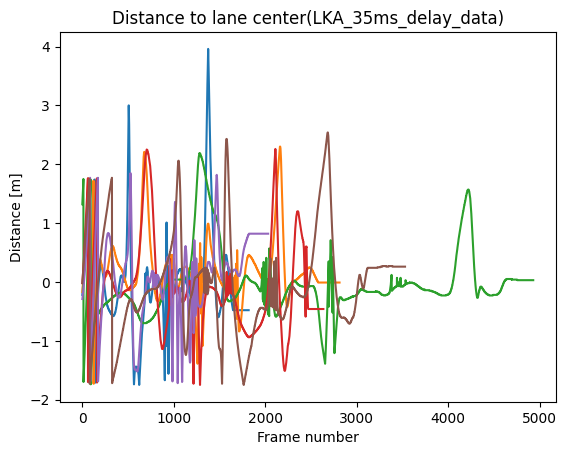

In [141]:
for i in range(6):
    plt.plot(range(len(LKA_35ms_delay_data[i]['distance'][LKA_35ms_delay_data[i]['distance'].count(-0.31):])), LKA_35ms_delay_data[i]['distance'][LKA_35ms_delay_data[i]['distance'].count(-0.31):])

plt.ylabel('Distance [m]')
plt.xlabel('Frame number')
plt.title('Distance to lane center(LKA_35ms_delay_data)')
# # Set x-axis limit to start from 0
# plt.xlim(xmin=0) 

# # Set y-axis limit to start from 0
# plt.ylim(ymin=0)
# plt.ylim(-2,2)  
plt.show()

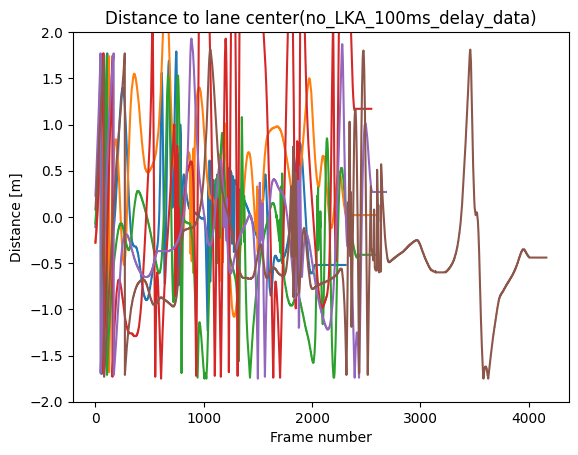

In [142]:
for i in range(6):
    plt.plot(range(len(no_LKA_100ms_delay_data[i]['distance'][no_LKA_100ms_delay_data[i]['distance'].count(-0.31):])), no_LKA_100ms_delay_data[i]['distance'][no_LKA_100ms_delay_data[i]['distance'].count(-0.31):])

plt.ylabel('Distance [m]')
plt.xlabel('Frame number')
plt.title('Distance to lane center(no_LKA_100ms_delay_data)')
# # Set x-axis limit to start from 0
# plt.xlim(xmin=0) 

# # Set y-axis limit to start from 0
# plt.ylim(ymin=0) 
plt.ylim(-2,2) 
plt.show()

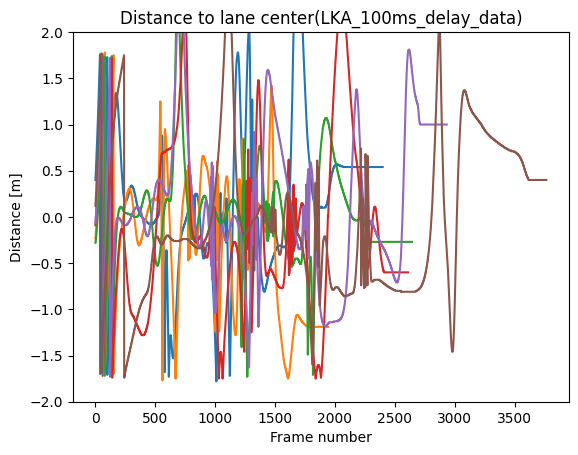

In [143]:
for i in range(6):
    plt.plot(range(len(LKA_100ms_delay_data[i]['distance'][LKA_100ms_delay_data[i]['distance'].count(-0.31):])), LKA_100ms_delay_data[i]['distance'][LKA_100ms_delay_data[i]['distance'].count(-0.31):])

plt.ylabel('Distance [m]')
plt.xlabel('Frame number')
plt.title('Distance to lane center(LKA_100ms_delay_data)')
# # Set x-axis limit to start from 0
# plt.xlim(xmin=0) 

# # Set y-axis limit to start from 0
# plt.ylim(ymin=0) 
plt.ylim(-2,2) 
plt.show()

In [144]:
LKA_20ms_delay = []
LKA_35ms_delay = []
LKA_100ms_delay = []
LKA_no_delay = []

no_LKA_20ms_delay = []
no_LKA_35ms_delay = []
no_LKA_100ms_delay = []
no_LKA_no_delay = []
average_data_list = [no_LKA_no_delay, LKA_no_delay, no_LKA_20ms_delay,LKA_20ms_delay,  no_LKA_35ms_delay,LKA_35ms_delay,no_LKA_100ms_delay, LKA_100ms_delay  ]      

## Average and standard Dev

In [145]:
for i in range(8):
    for j in range(6):
        average_data_list[i].extend(follow_data_list[i][j]['distance'][follow_data_list[i][j]['distance'].count(-0.31):])
for data_list in average_data_list:
    
    cleaned_data = []
    for item in data_list:
        try:
            # Try to convert each item to a float
            cleaned_data.append(float(item))
        except (ValueError, TypeError):
            # If it fails (e.g., it's a non-numeric string like 'N/A'), just skip it
            continue


average_data_list = []
std_dev_data_list = []
for data in follow_data_list:
    all_distances = []
    for i in range(len(data)):
        # The first few values are not part of the actual data, so we skip them
        cleaned_data = data[i]['distance'][data[i]['distance'].count(-0.31):]
        all_distances.extend(cleaned_data)
    all_distances = np.abs(all_distances)
    average_data_list.append(statistics.mean(all_distances))
    std_dev_data_list.append(statistics.stdev(all_distances))

results_df = pd.DataFrame({
    'Average(m)': average_data_list,
    'Standard Deviation(m)': std_dev_data_list
}, index=average_data_list_name)

print(results_df)

                    Average(m)  Standard Deviation(m)
no_LKA_no_delay       0.443272               0.512676
LKA_no_delay          0.483767               0.514754
no_LKA_20ms_delay     0.615520               0.534896
LKA_20ms_delay        0.484126               0.515264
no_LKA_35ms_delay     0.605327               0.548862
LKA_35ms_delay        0.641271               0.515722
no_LKA_100ms_delay    0.687195               0.598356
LKA_100ms_delay       0.607014               0.553348


## Lane crossing count

In [146]:
LKA_20ms_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Free ride lane cross data/20ms_delay_LKA"
LKA_35ms_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Free ride lane cross data/35ms_delay_LKA"
LKA_100ms_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Free ride lane cross data/100ms_delay_LKA"
LKA_no_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Free ride lane cross data/no_delay_LKA"

no_LKA_20ms_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Free ride lane cross data/20ms_delay_no_LKA"
no_LKA_35ms_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Free ride lane cross data/35ms_delay_no_LKA"
no_LKA_100ms_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Free ride lane cross data/100ms_delay_no_LKA"
no_LKA_no_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Free ride lane cross data/no_delay_no_LKA"

LKA_20ms_delay_data = read_all_json_files_in_directory(LKA_20ms_delay)
LKA_35ms_delay_data = read_all_json_files_in_directory(LKA_35ms_delay)
LKA_100ms_delay_data = read_all_json_files_in_directory(LKA_100ms_delay)
LKA_no_delay_data = read_all_json_files_in_directory(LKA_no_delay)

no_LKA_20ms_delay_data = read_all_json_files_in_directory(no_LKA_20ms_delay)
no_LKA_35ms_delay_data = read_all_json_files_in_directory(no_LKA_35ms_delay)
no_LKA_100ms_delay_data = read_all_json_files_in_directory(no_LKA_100ms_delay)
no_LKA_no_delay_data = read_all_json_files_in_directory(no_LKA_no_delay)
follow_data_list=[LKA_20ms_delay_data,LKA_35ms_delay_data,LKA_100ms_delay_data,LKA_no_delay_data,no_LKA_20ms_delay_data,no_LKA_35ms_delay_data,no_LKA_100ms_delay_data,no_LKA_no_delay_data]
# for a in follow_data_list:
#     for i in range(6):
#         for j in range(len(a[i]['distance'])):
#             a[i]['distance'][j]=round(a[i]['distance'][j],2)
   

Found 6 files to process.
Found 6 files to process.
Found 6 files to process.
Found 6 files to process.
Found 6 files to process.
Found 6 files to process.
Found 6 files to process.
Found 6 files to process.


In [147]:
data_list = []
for list in follow_data_list:
    all_data=[]
    for i in range(6):
        all_data.extend([list[i]['crossings_by_type']['Solid'] + list[i]['crossings_by_type']['Broken']])
    data_list.append(statistics.mean(all_data))

results_df = pd.DataFrame({
    'Average': data_list}, index=average_data_list_name)
print(results_df)

                      Average
no_LKA_no_delay     11.666667
LKA_no_delay        12.166667
no_LKA_20ms_delay   12.500000
LKA_20ms_delay      12.500000
no_LKA_35ms_delay   11.833333
LKA_35ms_delay      11.833333
no_LKA_100ms_delay  14.833333
LKA_100ms_delay     12.500000


In [148]:
data_list = []
for list in follow_data_list:
    all_data=[]
    for i in range(6):
        all_data.extend([list[i]['total_crossings']])
    data_list.append(statistics.mean(all_data))

results_df = pd.DataFrame({
    'Average': data_list}, index=average_data_list_name)
print(results_df)

                      Average
no_LKA_no_delay     39.166667
LKA_no_delay        38.333333
no_LKA_20ms_delay   41.000000
LKA_20ms_delay      39.333333
no_LKA_35ms_delay   38.833333
LKA_35ms_delay      38.833333
no_LKA_100ms_delay  43.000000
LKA_100ms_delay     38.000000


In [149]:
no_LKA_20ms_delay_data

[{'crossings_by_type': {'Broken': 5, 'NONE': 23, 'Solid': 8},
  'total_crossings': 36},
 {'crossings_by_type': {'Broken': 4, 'NONE': 22, 'Solid': 9},
  'total_crossings': 35},
 {'crossings_by_type': {'Broken': 2, 'NONE': 32, 'Solid': 8},
  'total_crossings': 42},
 {'crossings_by_type': {'Broken': 2, 'NONE': 29, 'Solid': 10},
  'total_crossings': 41},
 {'crossings_by_type': {'Broken': 4, 'NONE': 28, 'Solid': 8},
  'total_crossings': 40},
 {'crossings_by_type': {'Broken': 3, 'NONE': 28, 'Solid': 8},
  'total_crossings': 39}]

In [150]:
no_LKA_20ms_delay_data[1]['crossings_by_type']

{'Broken': 4, 'NONE': 22, 'Solid': 9}

In [151]:
no_LKA_35ms_delay_data[1]['crossings_by_type']['Solid'] + no_LKA_35ms_delay_data[1]['crossings_by_type']['Broken']

10

# Scenario 1 Urban driving 30kmh

In [152]:
LKA_20ms_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Free ride data (30kmh)/20ms_delay_LKA"

LKA_100ms_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Free ride data (30kmh)/100ms_delay_LKA"
LKA_no_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Free ride data (30kmh)/no_delay_LKA"

no_LKA_20ms_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Free ride data (30kmh)/20ms_delay_no_LKA"

no_LKA_100ms_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Free ride data (30kmh)/100ms_delay_no_LKA"
no_LKA_no_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Free ride data (30kmh)/no_delay_no_LKA"

LKA_20ms_delay_data = read_all_json_files_in_directory(LKA_20ms_delay)

LKA_100ms_delay_data = read_all_json_files_in_directory(LKA_100ms_delay)
LKA_no_delay_data = read_all_json_files_in_directory(LKA_no_delay)

no_LKA_20ms_delay_data = read_all_json_files_in_directory(no_LKA_20ms_delay)

no_LKA_100ms_delay_data = read_all_json_files_in_directory(no_LKA_100ms_delay)
no_LKA_no_delay_data = read_all_json_files_in_directory(no_LKA_no_delay)
follow_data_list=[LKA_20ms_delay_data,LKA_100ms_delay_data,LKA_no_delay_data,no_LKA_20ms_delay_data,no_LKA_100ms_delay_data,no_LKA_no_delay_data]
for a in follow_data_list:
    for i in range(4):
        for j in range(len(a[i]['distance'])):
            a[i]['distance'][j]=round(a[i]['distance'][j],2)
   

Found 4 files to process.
Found 4 files to process.
Found 4 files to process.
Found 4 files to process.
Found 4 files to process.
Found 4 files to process.


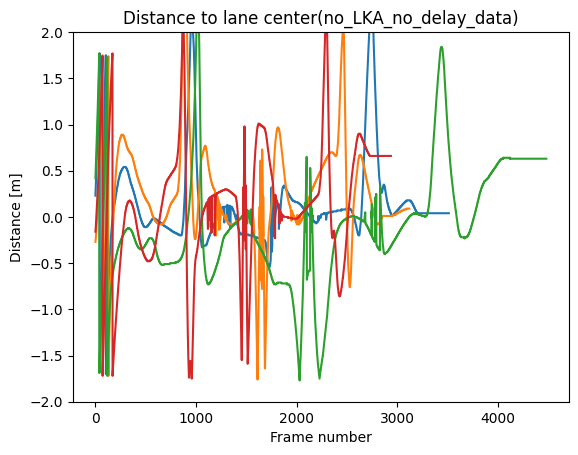

In [153]:
for i in range(4):
    plt.plot(range(len(no_LKA_no_delay_data[i]['distance'][no_LKA_no_delay_data[i]['distance'].count(-0.31):])), no_LKA_no_delay_data[i]['distance'][no_LKA_no_delay_data[i]['distance'].count(-0.31):])

plt.ylabel('Distance [m]')
plt.xlabel('Frame number')
plt.title('Distance to lane center(no_LKA_no_delay_data)')
# # Set x-axis limit to start from 0
# plt.xlim(xmin=0) 

# # Set y-axis limit to start from 0
# plt.ylim(ymin=0) 
plt.ylim(-2,2) 
plt.show()

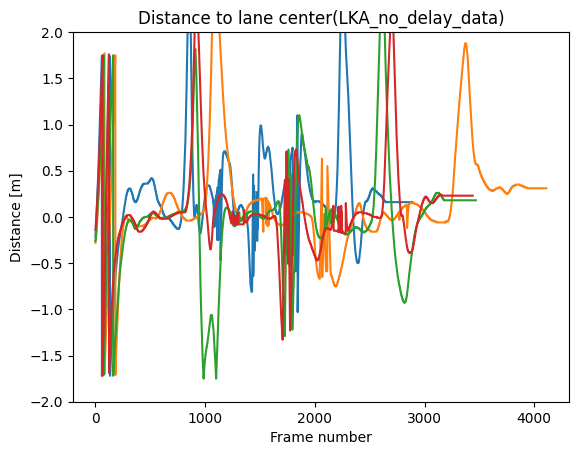

In [154]:
for i in range(4):
    plt.plot(range(len(LKA_no_delay_data[i]['distance'][LKA_no_delay_data[i]['distance'].count(-0.31):])), LKA_no_delay_data[i]['distance'][LKA_no_delay_data[i]['distance'].count(-0.31):])

plt.ylabel('Distance [m]')
plt.xlabel('Frame number')
plt.title('Distance to lane center(LKA_no_delay_data)')
# # Set x-axis limit to start from 0
# plt.xlim(xmin=0) 

# # Set y-axis limit to start from 0
plt.ylim(-2,2) 
plt.show()

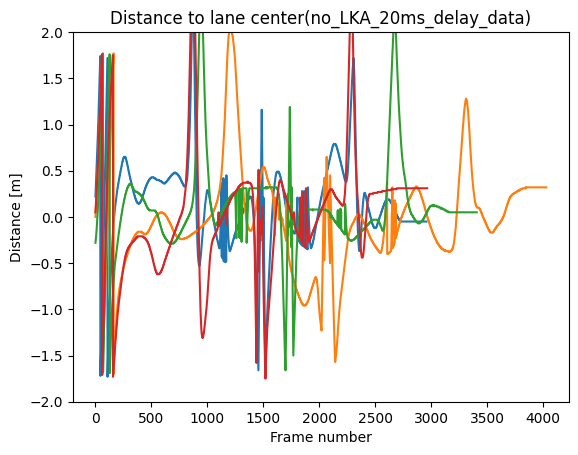

In [155]:
for i in range(4):
    plt.plot(range(len(no_LKA_20ms_delay_data[i]['distance'][no_LKA_20ms_delay_data[i]['distance'].count(-0.31):])), no_LKA_20ms_delay_data[i]['distance'][no_LKA_20ms_delay_data[i]['distance'].count(-0.31):])

plt.ylabel('Distance [m]')
plt.xlabel('Frame number')
plt.title('Distance to lane center(no_LKA_20ms_delay_data)')
# # Set x-axis limit to start from 0
# plt.xlim(xmin=0) 

# # Set y-axis limit to start from 0
# plt.ylim(ymin=0) 
plt.ylim(-2,2) 
plt.show()

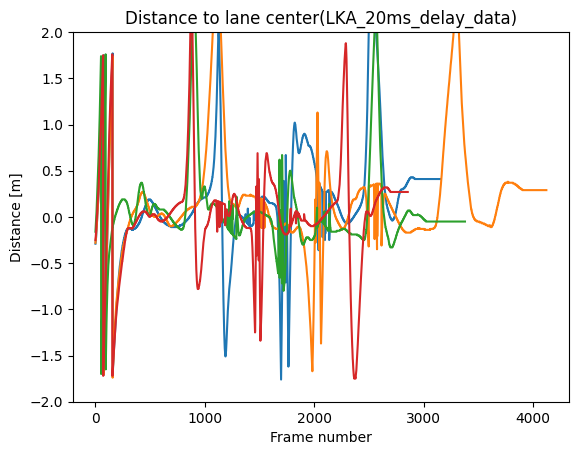

In [156]:
for i in range(4):
    plt.plot(range(len(LKA_20ms_delay_data[i]['distance'][LKA_20ms_delay_data[i]['distance'].count(-0.31):])), LKA_20ms_delay_data[i]['distance'][LKA_20ms_delay_data[i]['distance'].count(-0.31):])

plt.ylabel('Distance [m]')
plt.xlabel('Frame number')
plt.title('Distance to lane center(LKA_20ms_delay_data)')
# # Set x-axis limit to start from 0
# plt.xlim(xmin=0) 

# # Set y-axis limit to start from 0
# plt.ylim(ymin=0) 
plt.ylim(-2,2) 
plt.show()

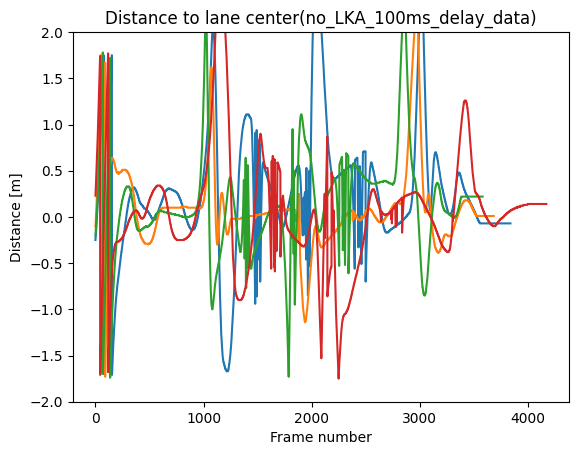

In [157]:
for i in range(4):
    plt.plot(range(len(no_LKA_100ms_delay_data[i]['distance'][no_LKA_100ms_delay_data[i]['distance'].count(-0.31):])), no_LKA_100ms_delay_data[i]['distance'][no_LKA_100ms_delay_data[i]['distance'].count(-0.31):])

plt.ylabel('Distance [m]')
plt.xlabel('Frame number')
plt.title('Distance to lane center(no_LKA_100ms_delay_data)')
# # Set x-axis limit to start from 0
# plt.xlim(xmin=0) 

# # Set y-axis limit to start from 0
# plt.ylim(ymin=0) 
plt.ylim(-2,2) 
plt.show()

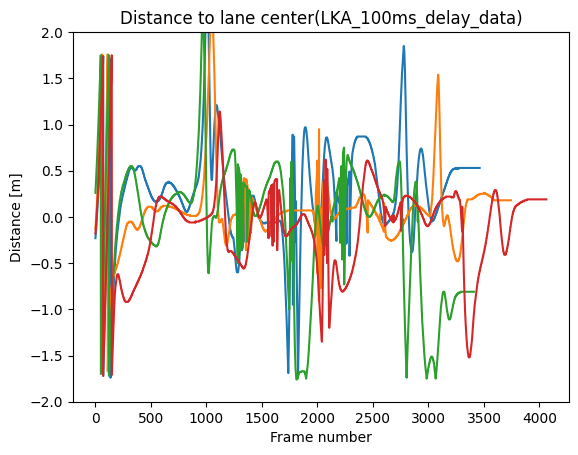

In [158]:
for i in range(4):
    plt.plot(range(len(LKA_100ms_delay_data[i]['distance'][LKA_100ms_delay_data[i]['distance'].count(-0.31):])), LKA_100ms_delay_data[i]['distance'][LKA_100ms_delay_data[i]['distance'].count(-0.31):])

plt.ylabel('Distance [m]')
plt.xlabel('Frame number')
plt.title('Distance to lane center(LKA_100ms_delay_data)')
# # Set x-axis limit to start from 0
# plt.xlim(xmin=0) 

# # Set y-axis limit to start from 0
# plt.ylim(ymin=0) 
plt.ylim(-2,2) 
plt.show()

In [159]:
LKA_20ms_delay = []

LKA_100ms_delay = []
LKA_no_delay = []

no_LKA_20ms_delay = []

no_LKA_100ms_delay = []
no_LKA_no_delay = []
average_data_list = [no_LKA_no_delay, LKA_no_delay, no_LKA_20ms_delay,LKA_20ms_delay,no_LKA_100ms_delay, LKA_100ms_delay  ]   
average_data_list_name= ['no_LKA_no_delay', 'LKA_no_delay', 'no_LKA_20ms_delay','LKA_20ms_delay', 'no_LKA_100ms_delay','LKA_100ms_delay' ]   

## Average and standard Dev

In [160]:
for i in range(6):
    for j in range(4):
        average_data_list[i].extend(follow_data_list[i][j]['distance'][follow_data_list[i][j]['distance'].count(-0.31):])
for data_list in average_data_list:
    
    cleaned_data = []
    for item in data_list:
        try:
            # Try to convert each item to a float
            cleaned_data.append(float(item))
        except (ValueError, TypeError):
            # If it fails (e.g., it's a non-numeric string like 'N/A'), just skip it
            continue


average_data_list = []
std_dev_data_list = []
for data in follow_data_list:
    all_distances = []
    for i in range(len(data)):
        # The first few values are not part of the actual data, so we skip them
        cleaned_data = data[i]['distance'][data[i]['distance'].count(-0.31):]
        all_distances.extend(cleaned_data)
    all_distances = np.abs(all_distances)
    average_data_list.append(statistics.mean(all_distances))
    std_dev_data_list.append(statistics.stdev(all_distances))

results_df = pd.DataFrame({
    'Average(m)': average_data_list,
    'Standard Deviation(m)': std_dev_data_list
}, index=average_data_list_name)

print(results_df)

                    Average(m)  Standard Deviation(m)
no_LKA_no_delay       0.343650               0.484295
LKA_no_delay          0.381281               0.411614
no_LKA_20ms_delay     0.345046               0.484845
LKA_20ms_delay        0.376344               0.435861
no_LKA_100ms_delay    0.384656               0.479429
LKA_100ms_delay       0.419666               0.461799


## Lane crossing count

In [161]:
LKA_20ms_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Free ride lane cross data (30kmh)/20ms_delay_LKA"

LKA_100ms_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Free ride lane cross data (30kmh)/100ms_delay_LKA"
LKA_no_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Free ride lane cross data (30kmh)/no_delay_LKA"

no_LKA_20ms_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Free ride lane cross data (30kmh)/20ms_delay_no_LKA"

no_LKA_100ms_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Free ride lane cross data (30kmh)/100ms_delay_no_LKA"
no_LKA_no_delay = "/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Free ride lane cross data (30kmh)/no_delay_no_LKA"

LKA_20ms_delay_data = read_all_json_files_in_directory(LKA_20ms_delay)

LKA_100ms_delay_data = read_all_json_files_in_directory(LKA_100ms_delay)
LKA_no_delay_data = read_all_json_files_in_directory(LKA_no_delay)

no_LKA_20ms_delay_data = read_all_json_files_in_directory(no_LKA_20ms_delay)

no_LKA_100ms_delay_data = read_all_json_files_in_directory(no_LKA_100ms_delay)
no_LKA_no_delay_data = read_all_json_files_in_directory(no_LKA_no_delay)
follow_data_list=[LKA_20ms_delay_data,LKA_100ms_delay_data,LKA_no_delay_data,no_LKA_20ms_delay_data,no_LKA_100ms_delay_data,no_LKA_no_delay_data]
# for a in follow_data_list:
#     for i in range(6):
#         for j in range(len(a[i]['distance'])):
#             a[i]['distance'][j]=round(a[i]['distance'][j],2)
   

Found 4 files to process.
Found 4 files to process.
Found 4 files to process.
Found 4 files to process.
Found 4 files to process.
Found 4 files to process.


In [162]:
data_list = []
for list in follow_data_list:
    all_data=[]
    for i in range(4):
        all_data.extend([list[i]['crossings_by_type']['Solid'] + list[i]['crossings_by_type']['Broken']])
    data_list.append(statistics.mean(all_data))

results_df = pd.DataFrame({
    'Average': data_list}, index=average_data_list_name)
print(results_df)

                    Average
no_LKA_no_delay       11.75
LKA_no_delay          12.50
no_LKA_20ms_delay     10.75
LKA_20ms_delay        10.50
no_LKA_100ms_delay     9.75
LKA_100ms_delay       11.25


In [163]:
data_list = []
for list in follow_data_list:
    all_data=[]
    for i in range(4):
        all_data.extend([list[i]['total_crossings']])
    data_list.append(statistics.mean(all_data))

results_df = pd.DataFrame({
    'Average': data_list}, index=average_data_list_name)
print(results_df)

                    Average
no_LKA_no_delay       40.75
LKA_no_delay          43.25
no_LKA_20ms_delay     40.50
LKA_20ms_delay        38.00
no_LKA_100ms_delay    38.50
LKA_100ms_delay       40.25


In [164]:
no_LKA_20ms_delay_data

[{'crossings_by_type': {'Broken': 3, 'NONE': 22, 'Solid': 9},
  'total_crossings': 34},
 {'crossings_by_type': {'Broken': 3, 'NONE': 29, 'Solid': 7},
  'total_crossings': 39},
 {'crossings_by_type': {'Broken': 3, 'NONE': 30, 'Solid': 6},
  'total_crossings': 39},
 {'crossings_by_type': {'Broken': 3, 'NONE': 29, 'Solid': 8},
  'total_crossings': 40}]

# Average processing time of edge server

In [165]:
import csv
import os

def extract_mpc_processing_times(csv_file_path):
    """
    Reads a CSV file, filters for cells starting with a specific prefix,
    and extracts the numeric values that follow.

    Args:
        csv_file_path (str): The path to the input CSV file.

    Returns:
        list: A list of floating-point numbers representing the processing times.
    """
    prefix = "MPC Loop Avg Processing Time: "
    processing_times = []

    # First, check if the file actually exists to avoid errors.
    if not os.path.exists(csv_file_path):
        print(f"Error: File not found at '{csv_file_path}'")
        return processing_times

    try:
        # Open the file safely using a 'with' block.
        with open(csv_file_path, mode='r', encoding='utf-8', newline='') as infile:
            # The csv.reader handles the complexity of CSV parsing.
            reader = csv.reader(infile)
            for row_num, row in enumerate(reader, 1):
                # Check each cell in the current row.
                for cell in row:
                    # Remove leading/trailing whitespace from the cell.
                    cleaned_cell = cell.strip()
                    if cleaned_cell.startswith(prefix):
                        # Extract the substring that comes after the prefix.
                        value_str = cleaned_cell[len(prefix):]
                        value_str = value_str[0:5]
                        try:
                            # Convert the extracted string to a number (float).
                            time_value = float(value_str)
                            processing_times.append(time_value)
                        except ValueError:
                            # This handles cases where the value isn't a valid number.
                            print(f"Warning: Could not convert '{value_str}' to a number on row {row_num}.")
    except Exception as e:
        print(f"An error occurred while reading the file: {e}")

    return processing_times

# --- Example of How to Use the Function ---
if __name__ == "__main__":
    # Define the path to your CSV file.
    # IMPORTANT: Update this path if the file is not in the same directory as the script.
    file_path = '/home/engssg/Downloads/Untitled spreadsheet - Sheet1.csv'

    # For demonstration, we'll create a dummy CSV file if it doesn't exist.
    if not os.path.exists(file_path):
        print(f"Creating a dummy file '{file_path}' for this demonstration.")
        with open(file_path, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["Log Entry", "Timestamp"])
            writer.writerow(["Starting up services", "10:00:01"])
            writer.writerow(["MPC Loop Avg Processing Time: 0.0152", "10:00:02"])
            writer.writerow(["Sensor data received", "10:00:03"])
            writer.writerow(["  MPC Loop Avg Processing Time: 0.0149  ", "10:00:04"]) # With extra spaces
            writer.writerow(["MPC Loop Avg Processing Time: not_a_number", "10:00:05"]) # Invalid data
            writer.writerow(["MPC Loop Avg Processing Time: 0.0210", "10:00:06"])

    # Call the function to get the list of processing times.
    times = extract_mpc_processing_times(file_path)

    # Print the results and some basic statistics.
    if times:
        print("\nSuccessfully extracted processing times:")
        print(times)

        # Optional: Calculate and display statistics.
        average_time = sum(times) / len(times)
        max_time = max(times)
        min_time = min(times)
        standard_deviation = (sum((x - average_time) ** 2 for x in times) / len(times)) ** 0.5

        print("\n--- Statistics ---")
        print(f"Total values found: {len(times)}")
        print(f"Average Time: {average_time:.4f} seconds")
        print(f"Maximum Time: {max_time:.4f} seconds")
        print(f"Minimum Time: {min_time:.4f} seconds")
        print(f"Standard Deviation: {standard_deviation:.4f} seconds")
    else:
        print("\nNo valid 'MPC Loop Avg Processing Time' values were found in the file.")




Successfully extracted processing times:
[37.51, 32.96, 33.02, 32.83, 32.87, 33.08, 32.78, 32.67, 31.88, 32.23, 32.36, 32.73, 33.25, 33.35, 33.48, 33.34, 33.55, 33.84, 34.53, 35.44, 36.19, 37.08, 37.73, 38.56, 38.35, 38.2, 34.27, 33.19, 32.52, 31.5, 31.45, 31.46, 31.53, 31.5, 31.66, 31.46, 31.15, 31.14, 31.24, 31.78, 32.38, 32.61, 32.64, 32.88, 32.9, 33.45, 33.85, 34.48, 35.0, 35.55, 35.82, 35.8, 36.03, 36.4, 36.93, 37.41, 37.39, 33.75, 32.83, 32.59, 32.44, 32.45, 32.95, 33.05, 32.96, 32.63, 32.75, 33.23, 33.47, 33.77, 33.8, 34.08, 34.58, 35.11, 35.49, 35.89, 36.08, 36.56, 37.22, 37.66, 37.99, 38.2, 32.46, 32.48, 32.51, 32.57, 32.47, 32.26, 31.64, 31.66, 31.48, 31.78, 32.38, 32.93, 33.91, 34.11, 34.24, 34.25, 33.99, 34.59, 34.96, 35.59, 35.77, 36.04, 36.48, 36.9, 37.19, 37.39, 37.34, 37.29, 32.21, 32.78, 33.02, 33.15, 33.47, 33.48, 33.31, 32.6, 32.05, 32.02, 32.29, 32.8, 33.22, 33.44, 33.48, 33.84, 34.38, 34.55, 34.88, 34.76, 35.13, 35.92, 36.5, 37.48, 37.76, 37.96, 38.09, 38.03, 38.2

## Average and standard Dev

In [168]:
client = carla.Client('localhost', 2000)
client.set_timeout(5.0)  # seconds
data=client.show_recorder_file_info("/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Freeride_4/Songmu_35ms_delay_LKA.log",show_all=True)
print(data)


RuntimeError: time-out of 5000ms while waiting for the simulator, make sure the simulator is ready and connected to localhost:2000

In [ ]:
data=client.show_recorder_file_info("/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Freeride_4/Songmu_35ms_delay_LKA.log",show_all=True)
print(data)

In [ ]:
client.replay_file("/home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Freeride_4/Songmu_35ms_delay_LKA.log",
                 0,      61.0,            0)

'Replaying File: /home/engssg/CARLA_0.9.15/PythonAPI/Recordings/Freeride_4/Songmu_35ms_delay_LKA.log\nTotal time recorded: 62.662\nReplaying from 0 s - 61 s (62.662 s) at 1.0x\nIgnoring Spectator camera\n'

In [ ]:
world = client.get_world()

In [ ]:
carla_map = world.get_map()
print(carla_map)

Map(name=Carla/Maps/Town04)


In [ ]:
ego_vehicle = world.get_actors().filter('vehicle.*')[0]
ego_location = ego_vehicle.get_location()

# Get the closest waypoint to the vehicle's location
# The project_to_road=True argument ensures the waypoint is on a road
waypoint = carla_map.get_waypoint(ego_location, project_to_road=True)